In [32]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
import dLux.utils as dlu

cmap = plt.get_cmap('inferno')
cmap.set_bad('k')

import warnings; warnings.simplefilter('ignore')


You will have used `bash ../data/MAST_2024-07-03T0023` to download the datasets - this should create a directory `..data/MAST_2024-07-03T0023/HST/` with many subdirectories, each of which contains a dataset. Let's explore one of these.

In [45]:
ddir = '../data/MAST_2024-07-03T0023-1/'
fname = ddir + 'HST/n8yj27020/n8yj27020_mos.fits'
#fname = ddir + 'HST/n8yj65010/n8yj65010_mos.fits'
fname = ddir + 'HST/n9nk01010/n9nk01010_mos.fits'

# n8yj: 2 3 ~6 ~27 38 ~40 ~49 ~~56 65
# n9nk: 1 ~~4 ~5 14 ~~15

# 16 is good binary

prog = 'n8yj'#'n9nk'#'n8yj'

num = 65#65

wv = '2'

fname = ddir + f'HST/{prog}{num:02}0{wv}0/{prog}{num:02}0{wv}0_mos.fits'

ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
fname = ddir + 'HST/n8ku01050_mos.fits'

ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname = ddir + 'HST/N43C02020/n43c02020_mos.fits'

data = fits.getdata(fname, ext=1)
data.shape
np.max(data)

np.float32(23808.537)

In [34]:
hdul =fits.open(fname)
hdul.info()
hdul.close()

Filename: ../data/MAST_2024-07-11T09_26_05.575Z/HST/N43CA5010/n43ca5010_mos.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     323   ()      
  1  SCI           1 ImageHDU       143   (286, 286)   float32   
  2  ERR           1 ImageHDU        71   (286, 286)   float32   
  3  DQ            1 ImageHDU        71   (286, 286)   int16   
  4  SAMP          1 ImageHDU        71   (286, 286)   int16   
  5  TIME          1 ImageHDU        71   (286, 286)   float32   


([], [])

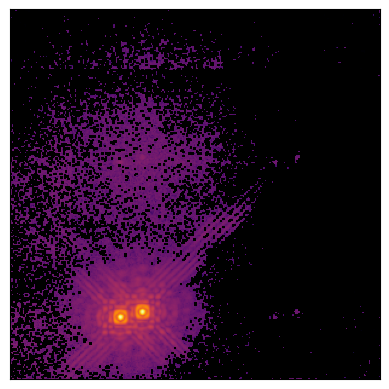

In [47]:
plt.imshow(data**0.125,cmap=cmap,origin='lower')
plt.xticks([])
plt.yticks([])


In [48]:
hdr = fits.getheader(fname, ext=0) # this is the overall header - with lots of metadata
print(hdr)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                   16 / Bits per pixel                                 NAXIS   =                    0 / Number of axes                                 EXTEND  =                    T / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        IRAF-TLM= '15:15:21 (04/11/2009)' / Time of last modification                   NEXTEND =                    5 / Number of standard extensions                  DATE    = '2009-11-04T15:15:21' / date this file was written (yyyy-mm-dd)       FILENAME= 'n43c02020_mos.fits' / name of file                                   FILETYPE= 'SCI      '          / type of data found in data file                                                                                                TELESCOP= 'HST'                / telescope used to acquire data                 INSTRUME= 'NICMOS'             / identif

In [49]:
metadata = { # this is the main subset of metadata we care about from the header 
    'tel'    : hdr['TELESCOP'],         # telescope - should be HST
    'fname'  : hdr['FILENAME'],         # original file name
    'ap'     : hdr['APERTURE'],
    'odate'  : hdr['DATE-OBS'],         # UTC date of observation
    'otime'  : hdr['TIME-OBS'],         # UTC time of observation
    'tint'   : hdr['EXPTIME' ],         # integration time (sec)
    'filter' : hdr['FILTER'],           # filter name - should be F110W, or F170W
    'RA'     : hdr['RA_TARG' ],         # right ascension (deg)
    'DEC'    : hdr['DEC_TARG'],         # declination (deg)
    'wavel' : hdr['PHOTPLAM']*1e-10, # central wavelength (meters)
    'orient' : hdr['ORIENTAT'] # P.A. of image y axis (deg e. of n.)
    }

print(metadata)

{'tel': 'HST', 'fname': 'n43c02020_mos.fits', 'ap': 'NIC1', 'odate': '1997-07-03', 'otime': '12:04:33', 'tint': 14.616, 'filter': 'F145M', 'RA': 170.5221038866, 'DEC': -24.77769065073, 'wavel': 1.4556700000000001e-06, 'orient': -99.6729}


In [50]:
image_hdr = fits.getheader(fname, ext=1) # this is the header for just the image in particular

# rather than manipulate WCS coordinates ourselves, can use https://docs.astropy.org/en/stable/wcs/
w = WCS(image_hdr)

In [52]:
w.proj_plane_pixel_scales()
#dlu.deg2arcsec(1.19930511e-05)

[<Quantity 1.20355109e-05 deg>, <Quantity 1.19808331e-05 deg>]

Let's crop this to something more manageable in size.

(100, 100)


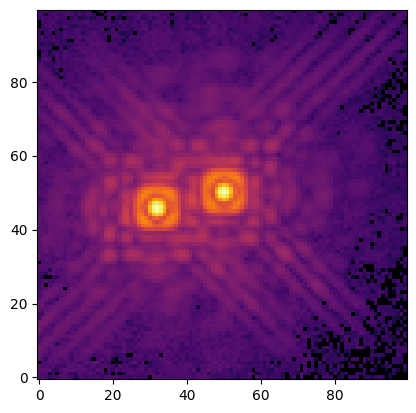

In [55]:
# get brightest pixel coordinates
y,x = np.unravel_index(np.argmax(data),data.shape)
centre = SkyCoord(w.pixel_to_world(x,y), unit='deg') # astropy wants to keep track of units


# use fits_cut because we want WCS metadata cropped appropriately
cutout = fits_cut(fname, centre, 100, single_outfile=False, memory_only=True)[0] 
cropped = cutout[1].data
cropped_image_hdr = cutout[1].header

print(cropped.shape)
plt.imshow(cropped**0.125,cmap=cmap,origin='lower');